In [1]:
%%capture
import os

# unzip data
if not os.path.exists('.data/data'):
  !unzip spotify_million_playlist_dataset.zip -d .data/

In [21]:
import glob
import json
import pandas as pd

lyrics = pd.read_csv('available_songs.csv', index_col=0, names=['artist_name', 'track_name'], header=0)

def process_file(filename):
    with open(filename, 'r') as file:
        content = json.load(file)
        playlists_data = pd.DataFrame([{'pid': playlist['pid'],
                           'track_uri': track['track_uri'],
                           'artist_name': track['artist_name'],
                           'track_name': track['track_name']}
                          for playlist in content['playlists']
                          for track in playlist['tracks']])
        playlists_data = pd.merge(playlists_data, lyrics, on=['artist_name', 'track_name'])
        playlists_data = playlists_data[playlists_data.groupby('pid')['track_uri'].transform('count') >= 30]
        playlists_data = playlists_data.drop(columns=['artist_name', 'track_name'])
    return playlists_data

In [22]:
file_prefix = ".data/data/*"

# process all files in directory
def playlist_generator():
    for filename in sorted(glob.glob(file_prefix)):
        yield process_file(filename)

In [23]:
playlist_track_df = pd.DataFrame()

# process data into dataframe with columns (pid, track_uri)
for playlists_chunk in playlist_generator():
    chunk_df = pd.DataFrame(playlists_chunk)
    playlist_track_df = pd.concat([playlist_track_df, chunk_df], ignore_index=True)

# Display the DataFrame
playlist_track_df.head()

,pid,track_uri
0,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
1,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
2,0,spotify:track:0XUfyU2QviPAs6bxSpXYG4
3,0,spotify:track:68vgtRHr7iZHpzGpon6Jlo
4,0,spotify:track:3BxWKCI06eQ5Od8TY2JBeA


In [25]:
playlist_track_df['pid'].unique().shape

(103883,)

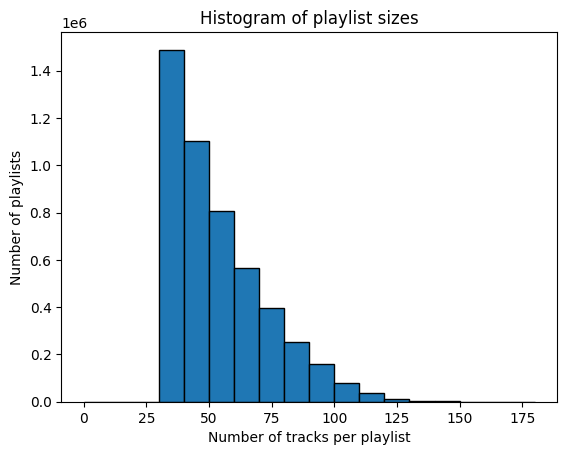

In [26]:
import matplotlib.pyplot as plt

# Grouping by 'pid' and counting 'trackid'
pid_counts = playlist_track_df.groupby('pid')['track_uri'].transform('count')

# Plotting histogram
plt.hist(pid_counts, bins=range(0, max(pid_counts)+10, 10), edgecolor='black')
plt.xlabel('Number of tracks per playlist')
plt.ylabel('Number of playlists')
plt.title('Histogram of playlist sizes')
plt.show()

In [27]:
import numpy as np

# create global mapping for trackid: track_uri
track_map = playlist_track_df['track_uri'].unique()
np.save('track_map', track_map)

# create local lookup for track_uri: trackid
lookup = {value: index for index, value in enumerate(track_map)}

# replace track_uri with trackid
playlist_track_df['trackid'] = playlist_track_df['track_uri'].apply(lambda x: lookup[x])
playlist_track_df = playlist_track_df.drop(['track_uri'], axis=1)
playlist_track_df.head()

,pid,trackid
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [28]:
import random

# get test pids
random_sample = random.sample(range(1000000), 200000)

# Create a boolean mask for test set
test_mask = playlist_track_df['pid'].isin(random_sample)

# Filter data into train and test sets based on the mask
test = playlist_track_df[test_mask]
train = playlist_track_df[~test_mask]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train['pid'] = train.groupby('pid').ngroup()
test['pid'] = test.groupby('pid').ngroup()

/var/folders/t0/r0qybgm95y5342ymf4p7rzg00000gn/T/ipykernel_48762/1673942246.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pid'] = train.groupby('pid').ngroup()
/var/folders/t0/r0qybgm95y5342ymf4p7rzg00000gn/T/ipykernel_48762/1673942246.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pid'] = test.groupby('pid').ngroup()


In [29]:
from sklearn.model_selection import train_test_split

# split test set into seen and unseen
test_X, test_y = train_test_split(test, test_size = 0.2, stratify=test['pid'])

In [30]:
from scipy import sparse

train_csr = sparse.coo_matrix((np.ones(len(train)), (train["pid"], train["trackid"])), shape=(train['pid'].nunique(), len(track_map))).tocsr()
test_X_csr = sparse.coo_matrix((np.ones(len(test_X)), (test_X["pid"], test_X["trackid"])), shape=(test_X['pid'].nunique(), len(track_map))).tocsr()
test_y_csr = sparse.coo_matrix((np.ones(len(test_y)), (test_y["pid"], test_y["trackid"])), shape=(test_y['pid'].nunique(), len(track_map))).tocsr()

In [31]:
from scipy.sparse import save_npz

save_npz("train_user_csr", train_csr)
save_npz("testx_user_csr", test_X_csr)
save_npz("testy_user_csr", test_y_csr)